In [10]:
import copy
from tqdm.auto import tqdm
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

from superprimitive_fusion.evaluation import (
    evaluate_mesh_pair,
    tsdf_fuse_from_depth_data,
    mse_and_iou,
)

In [15]:
names = (
    # ('mustard-bottle', 'mustard-bottle.obj'),
    # ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    # ('bleach', 'bleach.obj'),
    # ('pitcher', 'pitcher.obj'),
    # ('mug', 'mug.obj'),
    # ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

Getting the power-drill


In [16]:
centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [20]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 1000#360
height: int = 800#240
fov: float = 70.0
k: float = 5
max_normal_angle_deg = None
N = 12
radius = 0.25
include_depth_images = True

obj_scans = capture_spherical_scans(
    gt_mesh_list,
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-5,#2e-5,
    linear_uncertainty      =0,#2e-4,
    quadrt_uncertainty      =0,#3e-2,
    constant_perlin_sigma   =0,#2e-5,
    linear_perlin_sigma     =0,#2e-4,
    quadrt_perlin_sigma     =0,#3e-2,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =0,#1.0,
    include_depth_images=include_depth_images,
)

scan_mw_pairs = [(obj_scan['mesh'][0][0],obj_scan['mesh'][1][0]) for obj_scan in obj_scans]
if include_depth_images:
    depth_data = [obj_scan['mesh'][2] for obj_scan in obj_scans]
scan_meshes = [pair[0] for pair in scan_mw_pairs]

assert isinstance(scan_mw_pairs, list) and len(scan_mw_pairs) > 0, "scan_mw_pairs must be a non-empty list"
for i, (m, w) in enumerate(scan_mw_pairs):
    assert w.shape[0] == len(np.asarray(m.vertices)), f"weights length mismatch at pair {i}"

diff_mesh_colours = distinct_colours(len(scan_meshes))
diff_col_meshes = []
for i,mesh in enumerate(scan_meshes):
    if len(np.asarray(mesh.vertices)) == 0:
        continue
    col_mesh = copy.deepcopy(mesh)
    col_mesh.compute_vertex_normals()
    col_mesh.paint_uniform_color(diff_mesh_colours[i])
    diff_col_meshes.append(col_mesh)


front = look_at - (cam_offset + polar2cartesian(0.8, 110, 90))
front /= np.linalg.norm(front)
o3d.visualization.draw_geometries(
    geometry_list=diff_col_meshes,
    lookat=look_at,
    front=front,
    up=np.array([0, 0, 1]),
    zoom=0.7,
)

(<Figure size 1800x480 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

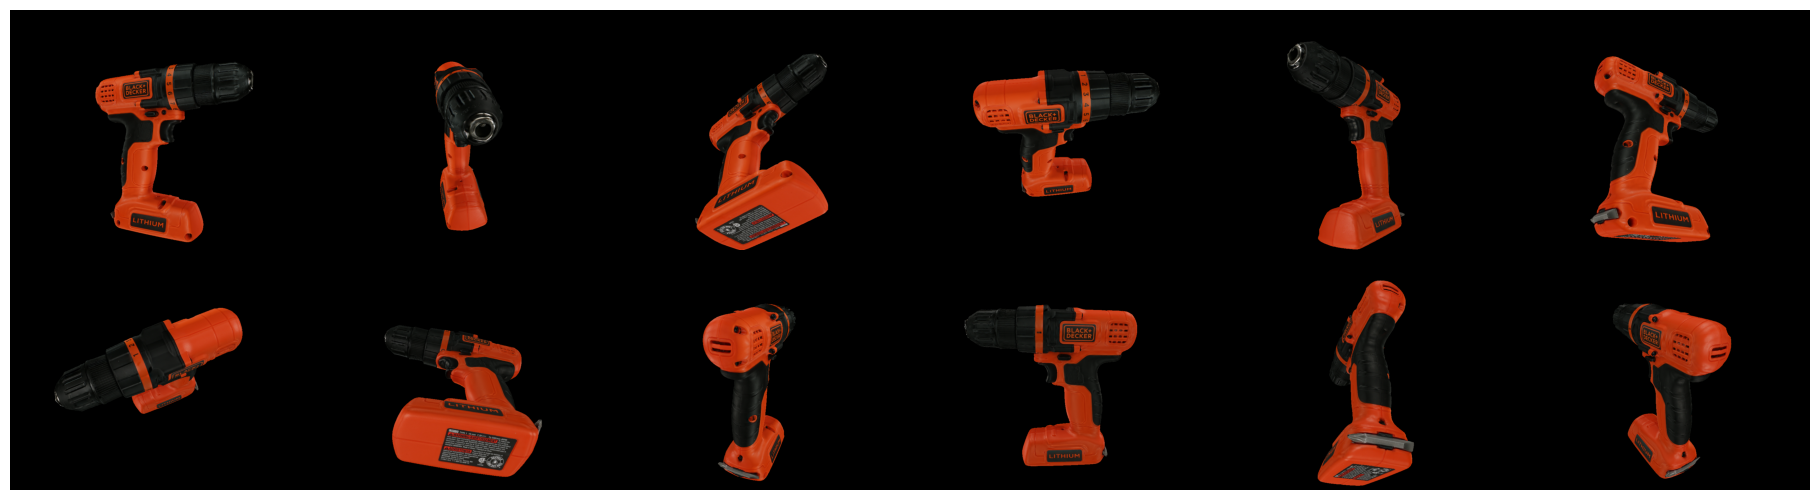

In [21]:
from superprimitive_fusion.utils import plot_images
rgbs = [np.flip(d['rgb'].copy(), axis=[0,1]) for d in depth_data]
depths = [np.flip(d['depth'], axis=[0,1]) for d in depth_data]
for i,rgb in enumerate(rgbs):
    rgb[~np.isfinite(depths[i])] = np.array([0,0,0])
plot_images(rgbs, max_cols=int(len(rgbs)/2))

In [ ]:
# cam_offset=obj_centre
# look_at = obj_centre
# width: int = 360
# height: int = 240
# fov: float = 70.0
# k: float = 5
# max_normal_angle_deg = None

# depth_data = []
# scans = []
# ccs = []
# a = 45
# c = 45
# rs = (0.35, 0.5, 1.0)
# ls = (90,90)
# for i in range(360//c):
#     r = rs[i%len(rs)]
#     l = ls[i%len(ls)]
#     ccs.append(cam_offset + polar2cartesian(r=r, lat=l, long=a+i*c))
# for cc in ccs:
#     object_meshes, object_weights, depth_image = virtual_mesh_scan(
#         gt_mesh_list,
#         cc,
#         look_at,
#         k=k,
#         max_normal_angle_deg=max_normal_angle_deg,
#         width_px=width,
#         height_px=height,
#         fov=fov,
#         constant_uncertainty    =2e-5,
#         linear_uncertainty      =1e-5,      # rate of uncertainty increase with depth
#         quadrt_uncertainty      =3e-3,      # quadratic uncertainty coefficient
#         constant_perlin_sigma   =2e-5,      # constant perlin noise term
#         linear_perlin_sigma     =1e-5,      # linear depth term
#         quadrt_perlin_sigma     =3e-3,      # quadratic depth term
#         perlin_octaves          =5,
#         seg_scale_std           =1e-8,#4,      # std of per-segment scale noise
#         rot_std                 =1e-8,#4,      # std of global rotation noise
#         trn_std                 =5e-8,#3,      # std of global translation noise
#         grazing_lambda          =2.0,       # sigma multiplier at grazing angles; 0 disables
#         seed                    =None,
#         include_depth_image     =True,
#     )
#     depth_data.append(depth_image)
#     for mesh in object_meshes:
#         mesh.compute_vertex_normals()
#     scans.append([(m,w) for m,w in zip(object_meshes, object_weights)])

# scan_mw_pairs = [scan[0] for scan in scans]
# all_meshes = [m for scan in scans for (m, _) in scan]

# dcols = distinct_colours(len(all_meshes), s=0.8)
# col_meshes = []
# for i,mesh in enumerate(all_meshes):
#     m = copy.deepcopy(mesh)
#     m.paint_uniform_color(dcols[i])
#     col_meshes.append(m)

# o3d.visualization.draw_geometries(col_meshes)

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [25]:
%%time
tsdf_lo_mesh = tsdf_fuse_from_depth_data(depth_data, voxel_length=1/1000, trunc_voxels=4)

CPU times: user 236 ms, sys: 73.6 ms, total: 310 ms
Wall time: 107 ms


In [26]:
o3d.visualization.draw_geometries([tsdf_lo_mesh])

In [19]:
%%time
tsdf_lo_mesh_smth = tsdf_lo_mesh.filter_smooth_simple(
    number_of_iterations=3
)
tsdf_lo_mesh_smth.compute_vertex_normals()

CPU times: user 52.1 ms, sys: 3.26 ms, total: 55.3 ms
Wall time: 55.2 ms


TriangleMesh with 91710 points and 177102 triangles.

In [10]:
o3d.visualization.draw_geometries([tsdf_lo_mesh_smth])

In [20]:
%%time
tsdf_hi_mesh = tsdf_fuse_from_depth_data(depth_data, voxel_length=1/4000, trunc_voxels=12)

CPU times: user 5.15 s, sys: 2.68 s, total: 7.83 s
Wall time: 3.04 s


In [23]:
o3d.visualization.draw_geometries([tsdf_hi_mesh])

In [23]:
%%time
tsdf_hi_mesh_smth = tsdf_hi_mesh.filter_smooth_simple(number_of_iterations=50)
tsdf_hi_mesh_smth.compute_vertex_normals()

CPU times: user 3.62 s, sys: 122 ms, total: 3.74 s
Wall time: 3.73 s


TriangleMesh with 1617386 points and 3196157 triangles.

In [202]:
o3d.visualization.draw_geometries([tsdf_hi_mesh_smth])

In [ ]:
spf_unc_mesh, spf_unc_weights = scan_mw_pairs[0]

for t, (mesh, weights) in enumerate(tqdm(scan_mw_pairs[1:], desc="Scan", unit="scan"), start=1):
    spf_unc_mesh, spf_unc_weights = fuse_meshes(
        mesh1=spf_unc_mesh, weights1=spf_unc_weights,
        mesh2=mesh,         weights2=weights,
        h_alpha=5.0, r_alpha=2.5,
        nrm_shift_iters=1, nrm_smth_iters=1,
        sigma_theta=0.05,
        normal_diff_thresh=5,
        ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        # ball_radius_percentiles=[10,50,90],
        bilateral_weight_update=False,
        shift_all=False,
    )

Scan:   0%|          | 0/11 [00:00<?, ?scan/s]

In [ ]:
o3d.visualization.draw_geometries([spf_unc_mesh])

In [8]:
spf_unc_nod_mesh, spf_unc_nod_weights = scan_mw_pairs[0]

for t, (mesh, weights) in enumerate(tqdm(scan_mw_pairs[1:], desc="Scan", unit="scan"), start=1):
    spf_unc_nod_mesh, spf_unc_nod_weights = fuse_meshes(
        mesh1=spf_unc_nod_mesh, weights1=spf_unc_nod_weights,
        mesh2=mesh,         weights2=weights,
        h_alpha=5.0, r_alpha=2.5,
        nrm_shift_iters=1, nrm_smth_iters=1,
        sigma_theta=0.05,
        normal_diff_thresh=5,
        ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        # ball_radius_percentiles=[10,50,90],
        bilateral_weight_update=False,
        shift_all=False,
        density_term=False,
    )

Scan:   0%|          | 0/7 [00:00<?, ?scan/s]

In [9]:
o3d.visualization.draw_geometries([spf_unc_nod_mesh])

In [31]:
spf_van_nrm_mesh, _ = scan_mw_pairs[0]

for t, (mesh, weights) in enumerate(tqdm(scan_mw_pairs[1:], desc="Scan", unit="scan"), start=1):
    spf_van_nrm_mesh, _ = fuse_meshes(
        mesh1=spf_van_nrm_mesh, weights1=None,
        mesh2=mesh,         weights2=None,
        h_alpha=5.0, r_alpha=2.5,
        nrm_shift_iters=1, nrm_smth_iters=1,
        sigma_theta=0.05,
        normal_diff_thresh=5,
        ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        # ball_radius_percentiles=[10,50,90],
        bilateral_weight_update=False,
        shift_all=False,
    )

Scan:   0%|          | 0/7 [00:00<?, ?scan/s]

In [32]:
o3d.visualization.draw_geometries([spf_van_nrm_mesh])

In [ ]:
spf_van_non_mesh, _ = scan_mw_pairs[0]

for t, (mesh, weights) in enumerate(tqdm(scan_mw_pairs[1:], desc="Scan", unit="scan"), start=1):
    spf_van_non_mesh, _ = fuse_meshes(
        mesh1=spf_van_non_mesh, weights1=None,
        mesh2=mesh,         weights2=None,
        h_alpha=5.0, r_alpha=2.5,
        nrm_shift_iters=1, nrm_smth_iters=1,
        sigma_theta=None,
        normal_diff_thresh=None,
        ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        # ball_radius_percentiles=[10,50,90],
        bilateral_weight_update=False,
        shift_all=False,
    )

Scan:   0%|          | 0/7 [00:00<?, ?scan/s]

In [9]:
o3d.visualization.draw_geometries([spf_van_non_mesh])

NameError: name 'spf_van_non_mesh' is not defined

In [ ]:
spf_van_mesh, _ = scan_mw_pairs[0]

for t, (mesh, weights) in enumerate(tqdm(scan_mw_pairs[1:], desc="Scan", unit="scan"), start=1):
    spf_van_mesh, _ = fuse_meshes(
        mesh1=spf_van_mesh, weights1=None,
        mesh2=mesh,         weights2=None,
        h_alpha=5.0, r_alpha=2.5,
        nrm_shift_iters=1, nrm_smth_iters=1,
        sigma_theta=None,
        normal_diff_thresh=None,
        ball_radius_percentiles=[0,1,5,10,15,25,35,50,65,75,85,90,95,99],
        # ball_radius_percentiles=[10,50,90],
        bilateral_weight_update=False,
        shift_all=False,
    )

Scan:   0%|          | 0/7 [00:00<?, ?scan/s]

In [ ]:
o3d.visualization.draw_geometries([spf_van_mesh])

In [ ]:
# rt = 'evaluation/2_noise/drill/2_drill_'
# ext = '.ply'
# meshes_and_names = [
#     # (spf_unc_mesh, 'spf_unc'),
#     # (spf_van_mesh, 'spf_van'), 
#     # (tsdf_lo_mesh, 'tsdf_lo'),
#     # (tsdf_lo_mesh_smth, 'tsdf_lo_smth'),
#     # (tsdf_hi_mesh, 'tsdf_hi'), 
#     # (tsdf_hi_mesh_smth, 'tsdf_hi_smth'),
# ]
# for mesh_to_write,fname in meshes_and_names:
#     ok = o3d.io.write_triangle_mesh(rt+fname+ext, mesh_to_write)
#     if not ok:
#         raise RuntimeError(f"Failed to write mesh: {fname}")

In [16]:
res = evaluate_mesh_pair(gt_mesh, spf_unc_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.


/Users/christopher/miniconda3/envs/msc-project/lib/python3.12/site-packages/trimesh/triangles.py:656: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


{'recon_to_gt': {'mean': 0.0004431652735809866, 'median': 0.00037252117545739927, 'rms': 0.0005606121498118183, 'p95': 0.0011128752828305556, 'p99': 0.0015372022853800873, 'hausdorff': 0.003170978157157389, 'trimmed_hausdorff_99': 0.0015372022853800873, 'count': 150000}, 'gt_to_recon': {'mean': 0.0015528419229805465, 'median': 0.0004804011588972132, 'rms': 0.0038372792215557758, 'p95': 0.008848719310848754, 'p99': 0.019653826183197255, 'hausdorff': 0.025677922987719103, 'trimmed_hausdorff_99': 0.019653826183197255, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.34604, 'recall': 0.27628, 'fscore': 0.3072500681321507}, 0.0005: {'tau_m': 0.0005, 'precision': 0.6404533333333333, 'recall': 0.5175733333333333, 'fscore': 0.5724938399422772}, 0.001: {'tau_m': 0.001, 'precision': 0.9278066666666667, 'recall': 0.7750933333333333, 'fscore': 0.8446024569329444}, 0.002: {'tau_m': 0.002, 'precision': 0.99836, 'recall': 0.8726533333333333, 'fscore': 0.931283776919459}}, 'norm

In [17]:
res = evaluate_mesh_pair(gt_mesh, spf_van_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.000530500558307597, 'median': 0.0004061833185930175, 'rms': 0.0007099017727994961, 'p95': 0.0014416297911530142, 'p99': 0.0022631782854544455, 'hausdorff': 0.0054559442417048435, 'trimmed_hausdorff_99': 0.0022631782854544455, 'count': 150000}, 'gt_to_recon': {'mean': 0.0016451692207715145, 'median': 0.0005464003416908308, 'rms': 0.0038581972307810044, 'p95': 0.008801568332555918, 'p99': 0.01956500753731549, 'hausdorff': 0.026070004142383463, 'trimmed_hausdorff_99': 0.01956500753731549, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.3249666666666667, 'recall': 0.2573066666666667, 'fscore': 0.28720563004011096}, 0.0005: {'tau_m': 0.0005, 'precision': 0.5864533333333334, 'recall': 0.46910666666666667, 'fscore': 0.521257282116707}, 0.001: {'tau_m': 0.001, 'precision': 0.86578, 'recall': 0.71226, 'fscore': 0.78155238498

In [203]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.00031113234794276915, 'median': 0.0002602846748217674, 'rms': 0.000393124729158196, 'p95': 0.0008042697028051088, 'p99': 0.0010518623135248003, 'hausdorff': 0.0019700456516795147, 'trimmed_hausdorff_99': 0.0010518623135248003, 'count': 150000}, 'gt_to_recon': {'mean': 0.0015554277384803568, 'median': 0.0003090878102899597, 'rms': 0.004140783510043779, 'p95': 0.009959941705874541, 'p99': 0.020507402398101122, 'hausdorff': 0.026166593981041066, 'trimmed_hausdorff_99': 0.020507402398101122, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.48284666666666665, 'recall': 0.41802, 'fscore': 0.4481008590246429}, 0.0005: {'tau_m': 0.0005, 'precision': 0.8094266666666666, 'recall': 0.6937133333333333, 'fscore': 0.7471161315941591}, 0.001: {'tau_m': 0.001, 'precision': 0.9825066666666666, 'recall': 0.8362533333333333, 'fscore': 

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_lo_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 0.0002814188811135735, 'median': 0.00022851997191103424, 'rms': 0.0003613208962162337, 'p95': 0.0007492023699074353, 'p99': 0.0010055376255478773, 'hausdorff': 0.0016501714893246977, 'trimmed_hausdorff_99': 0.0010055376255478773, 'count': 150000}, 'gt_to_recon': {'mean': 0.0016436794596613466, 'median': 0.00030407206506602447, 'rms': 0.004301640918440421, 'p95': 0.01041062631020541, 'p99': 0.02108143230331994, 'hausdorff': 0.026499253383038844, 'trimmed_hausdorff_99': 0.02108143230331994, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.5383866666666667, 'recall': 0.42662666666666665, 'fscore': 0.4760350992962677}, 0.0005: {'tau_m': 0.0005, 'precision': 0.84446, 'recall': 0.6845133333333333, 'fscore': 0.7561206161868966}, 0.001: {'tau_m': 0.001, 'precision': 0.9894933333333333, 'recall': 0.8223933333333333, 'fscore': 0

: 

In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.


In [ ]:
res = evaluate_mesh_pair(gt_mesh, tsdf_hi_mesh_smth, samples_per_mesh=150_000, taus_abs=(2.5e-4, 5e-4, 1e-3, 2e-3), debug=False)
print(res)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
{'recon_to_gt': {'mean': 4.0218280992706344e-05, 'median': 2.6730629010148638e-05, 'rms': 5.899231483567688e-05, 'p95': 0.00012463476736719695, 'p99': 0.00020388289148606987, 'hausdorff': 0.0005864445303115362, 'trimmed_hausdorff_99': 0.00020388289148606987, 'count': 150000}, 'gt_to_recon': {'mean': 4.0939152457329566e-05, 'median': 2.681771082832171e-05, 'rms': 6.124292454943795e-05, 'p95': 0.0001261646330278954, 'p99': 0.00021268393505686055, 'hausdorff': 0.0006705042776703474, 'trimmed_hausdorff_99': 0.00021268393505686055, 'count': 150000}, 'fscore': {0.00025: {'tau_m': 0.00025, 'precision': 0.9956266666666667, 'recall': 0.9939933333333333, 'fscore': 0.9948093295760553}, 0.0005: {'tau_m': 0.0005, 'precision': 0.99996, 'recall': 0.9997666666666667, 'fscore': 0.9998633239876116}, 0.001: {'tau_m': 0.001, 'precision': 1.0, 'recall': 1.0, 'fscore': 1.0}, 0.002: {'tau

In [292]:
spf_unc_eval_scans = capture_spherical_scans(
    [spf_unc_mesh],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

spf_unc_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in spf_unc_eval_scans]

/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:823: RuntimeWarning: invalid value encountered in matmul
  depth = ((verts_noised - cam_centre_np) @ L).clip(min=0.0)


In [293]:
spf_van_eval_scans = capture_spherical_scans(
    [spf_van_mesh],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

spf_van_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in spf_van_eval_scans]

In [294]:
tsdf_lo_eval_scans = capture_spherical_scans(
    [tsdf_lo_mesh],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

tsdf_lo_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in tsdf_lo_eval_scans]

In [295]:
tsdf_lo_smth_eval_scans = capture_spherical_scans(
    [tsdf_lo_mesh_smth],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

tsdf_lo_smth_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in tsdf_lo_smth_eval_scans]

In [296]:
tsdf_hi_eval_scans = capture_spherical_scans(
    [tsdf_hi_mesh],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

tsdf_hi_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in tsdf_hi_eval_scans]

In [297]:
tsdf_hi_smth_eval_scans = capture_spherical_scans(
    [tsdf_hi_mesh_smth],
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "fibonacci",#"latlong",
    constant_uncertainty    =2e-4,
    linear_uncertainty      =2e-3,
    quadrt_uncertainty      =1e-4,
    constant_perlin_sigma   =0,#2e-4,
    linear_perlin_sigma     =0,#2e-3,
    quadrt_perlin_sigma     =0,#1e-4,
    perlin_octaves          =3,
    seg_scale_std           =0,#1e-4,
    rot_std                 =0,#1e-4,
    trn_std                 =0,#1e-3,
    grazing_lambda          =1.0,
    include_depth_images=True,
)

tsdf_hi_smth_eval_depth_data = [obj_scan['mesh'][2] for obj_scan in tsdf_hi_smth_eval_scans]

In [305]:
print(mse_and_iou(depth_data, spf_unc_eval_depth_data)['overall'])

{'mse': 0.0007310324048725676, 'iou': 0.9962618713831751}


In [306]:
print(mse_and_iou(depth_data, spf_van_eval_depth_data)['overall'])

{'mse': 0.0008032237257825545, 'iou': 0.9952176150496602}


In [307]:
print(mse_and_iou(depth_data, tsdf_lo_eval_depth_data)['overall'])

{'mse': 0.002475293277673485, 'iou': 0.9912400398422077}


In [308]:
print(mse_and_iou(depth_data, tsdf_lo_smth_eval_depth_data)['overall'])

{'mse': 0.0038987847163544946, 'iou': 0.9964477576572089}


In [309]:
print(mse_and_iou(depth_data, tsdf_hi_eval_depth_data)['overall'])

{'mse': 0.0013685171037203126, 'iou': 0.9911962426501753}


In [310]:
print(mse_and_iou(depth_data, tsdf_hi_smth_eval_depth_data)['overall'])

{'mse': 0.003271854596404237, 'iou': 0.9983063692830487}


In [ ]:
def rgb_error_maps(depth_data_gt, depth_data_recon):
    out = []
    for gt, re in zip(depth_data_gt, depth_data_recon):
        rgb_gt = np.asarray(gt['rgb'])[..., :3]
        rgb_re = np.asarray(re['rgb'])[..., :3]
        rgb_gt = np.flip(rgb_gt)
        rgb_re = np.flip(rgb_re)

        out.append(np.linalg.norm(rgb_re - rgb_gt, axis=2))
    return out

In [50]:
rgb_error_maps_tsdf = rgb_error_maps(depth_data, tsdf_eval_depth_data)
rgb_error_maps_unc = rgb_error_maps(depth_data, unc_eval_depth_data)

In [51]:
import os

def plot_images(images, max_cols=5, titles=None, per_img_width=3, cmap=None, cbar_cols=None, cbar_kw=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n = len(images)
    h_to_w = images[0].shape[0] / images[0].shape[1]
    cols = max(1, min(max_cols, n))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*per_img_width, rows*per_img_width*h_to_w), squeeze=False)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i >= n: ax.axis('off'); continue
        img = images[i]
        arr = plt.imread(img) if isinstance(img, (str, os.PathLike)) else np.asarray(img)
        im = ax.imshow(arr, cmap=(cmap if arr.ndim == 2 else None))
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        if titles and i < len(titles) and titles[i]: ax.set_title(titles[i], fontsize=9, pad=2)
        if arr.ndim == 2 and cbar_cols and (i % cols) in cbar_cols:
            cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.02)
            fig.colorbar(im, cax=cax, **(cbar_kw or {}))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    return fig, axes[:n]


(<Figure size 1200x400 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

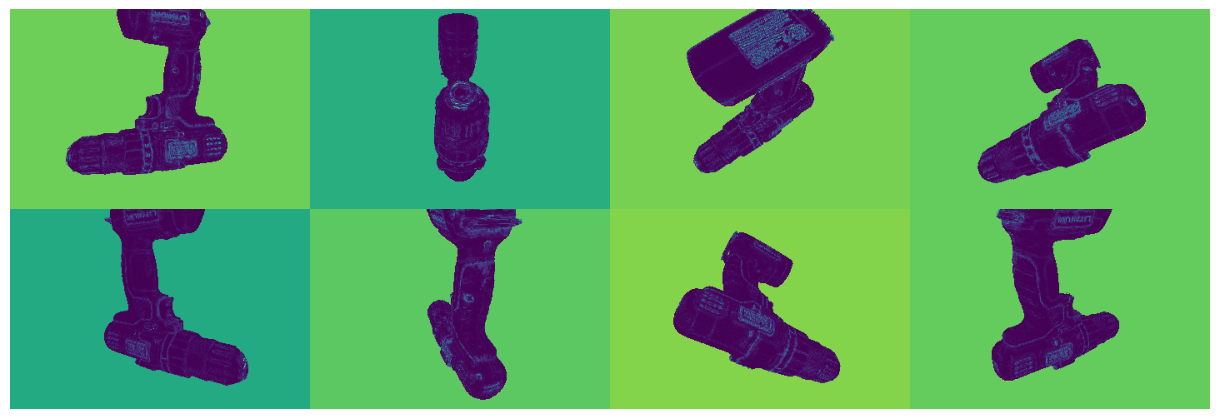

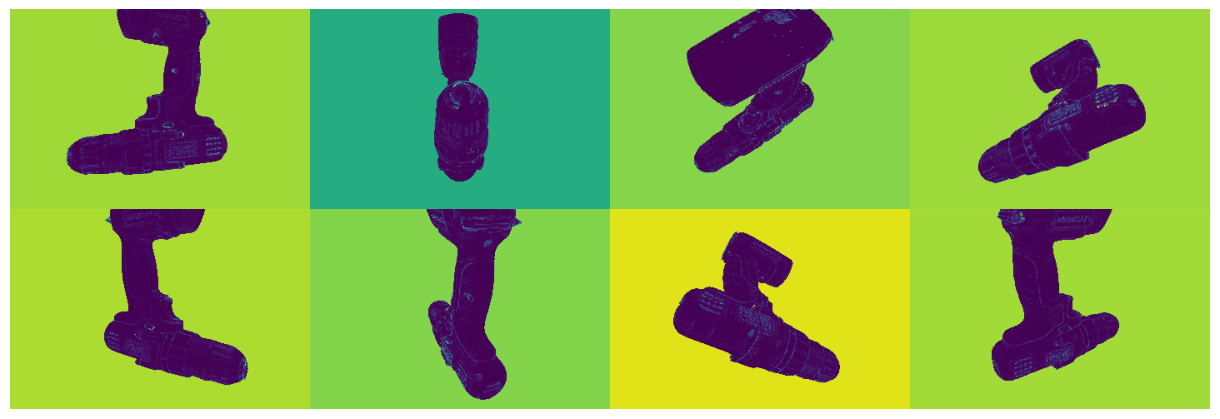

In [67]:
plot_images(rgb_error_maps_tsdf, max_cols=4)
plot_images(rgb_error_maps_unc, max_cols=4)